# Daily Bike Rental Prediction Through a Fully Connected NN

In this project, a fully connected neural network has been build, completely on numpy, and use it to predict daily bike rental ridership. 


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights.

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders.

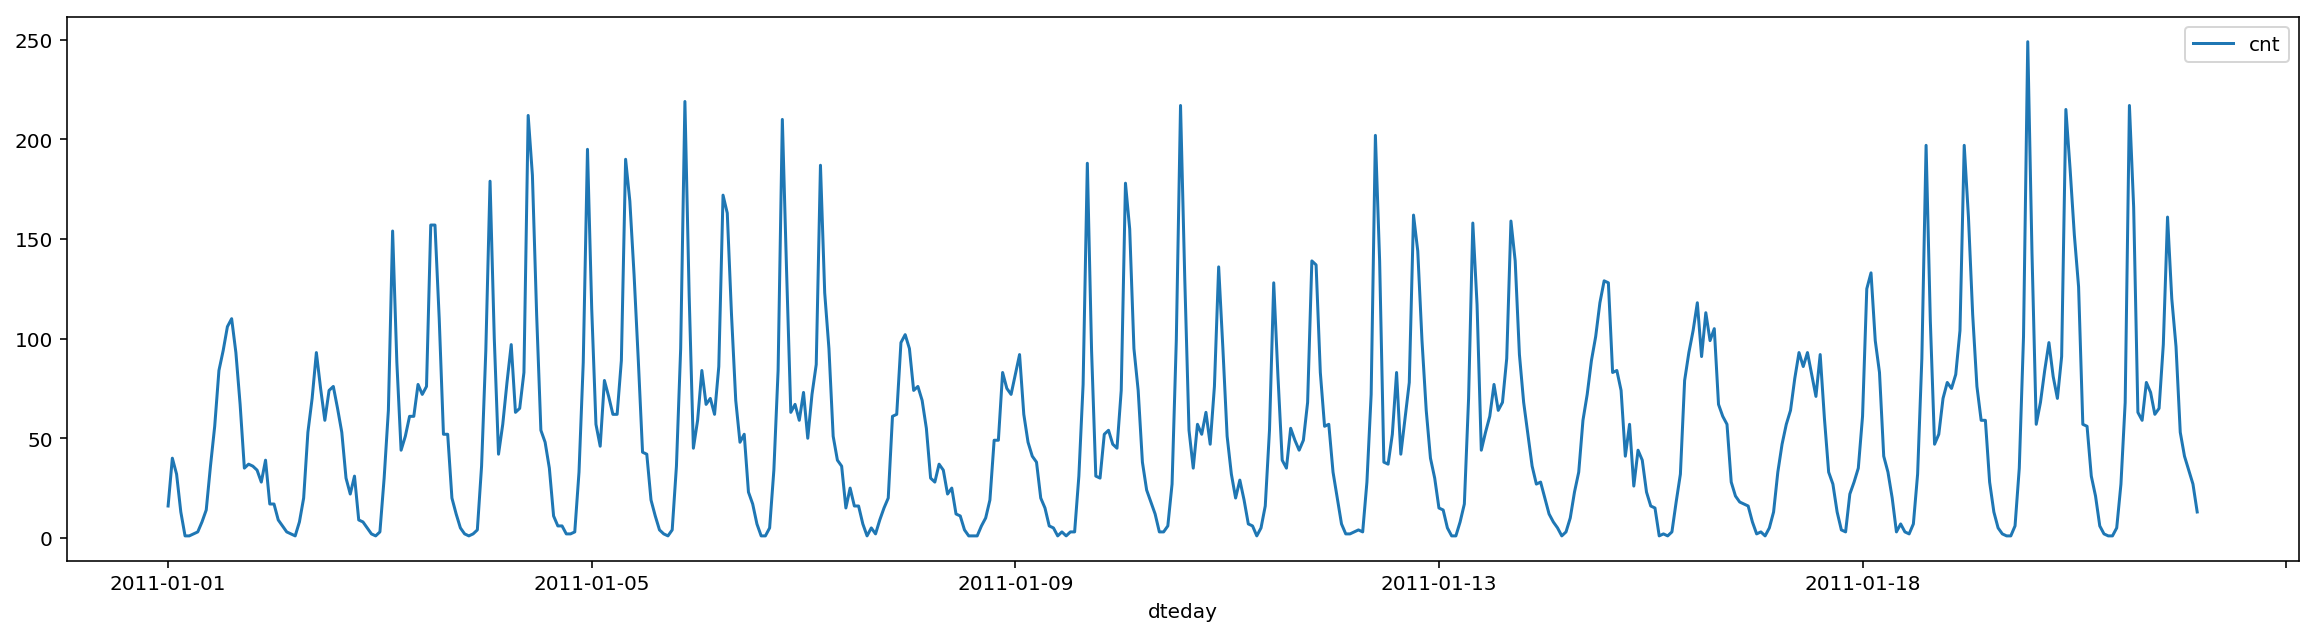

In [4]:
rides[:24*20].plot(x='dteday', y='cnt', figsize = (20,5))
plt.show()

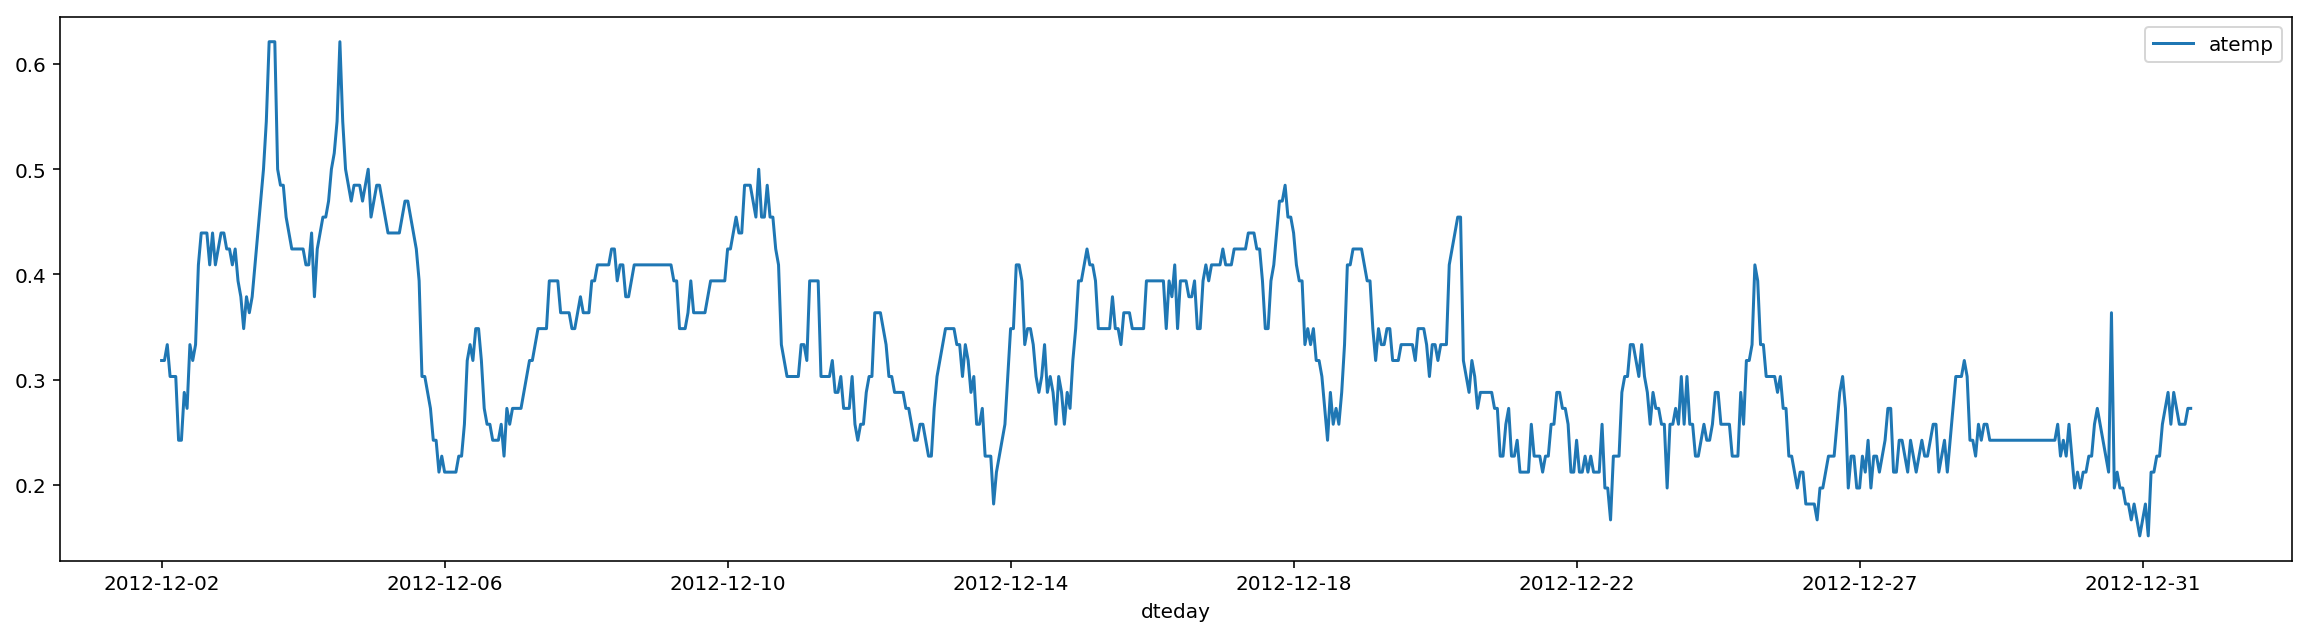

In [5]:
rides.loc[rides['dteday'] > '2012-12-01'].plot(x='dteday', y='atemp', figsize = (20,5))
plt.show()

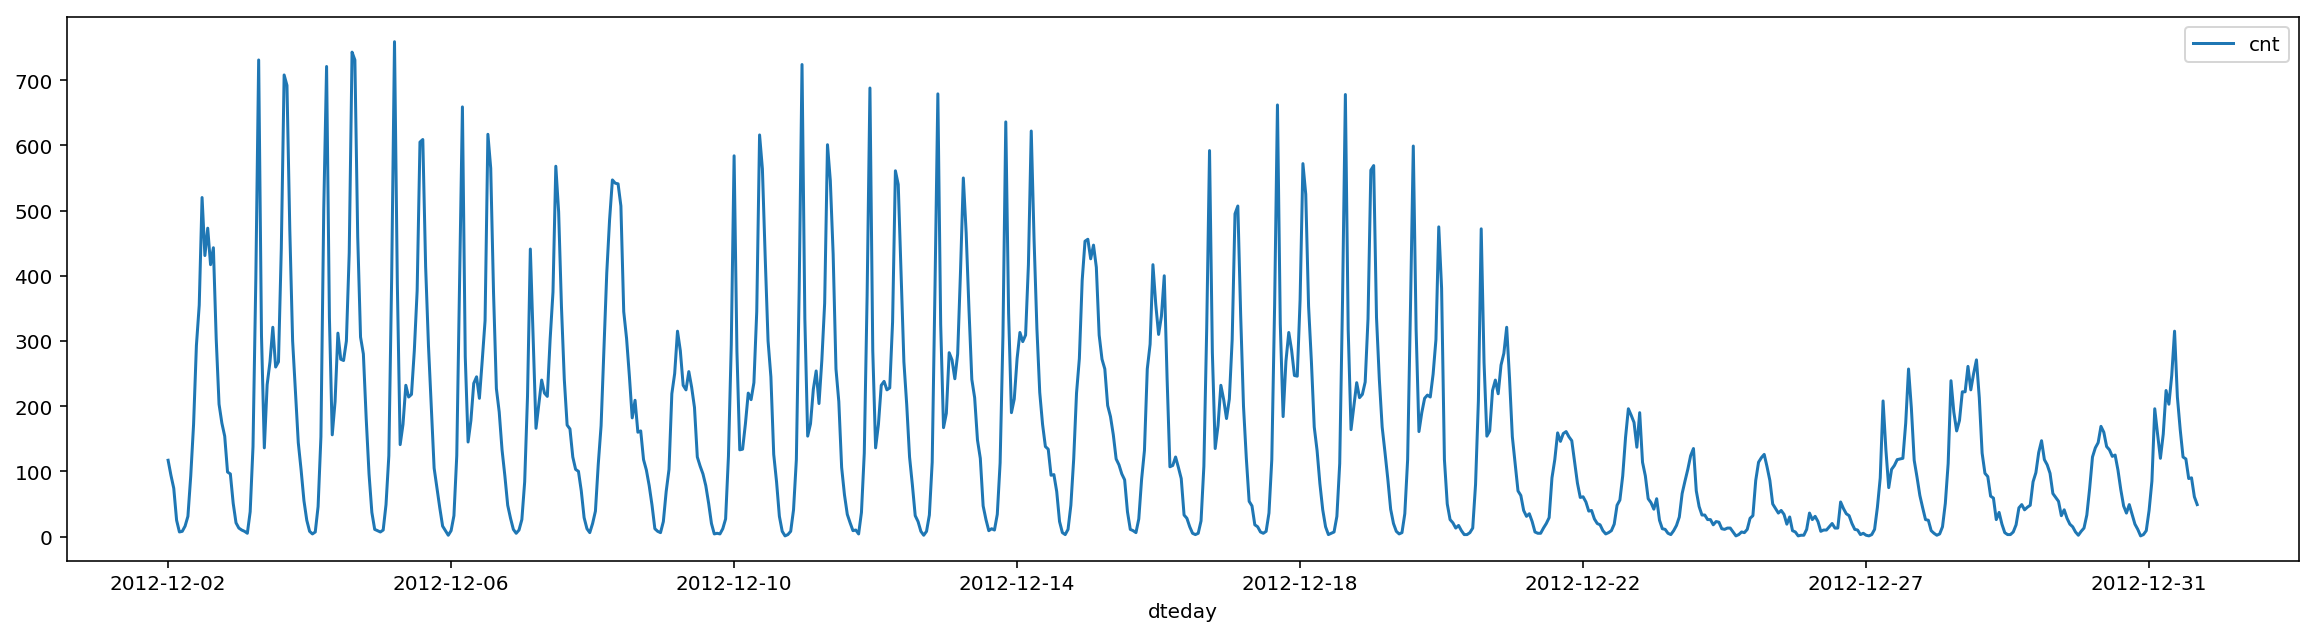

In [6]:
rides.loc[rides['dteday'] > '2012-12-01'].plot(x='dteday', y='cnt', figsize = (20,5))
plt.show()

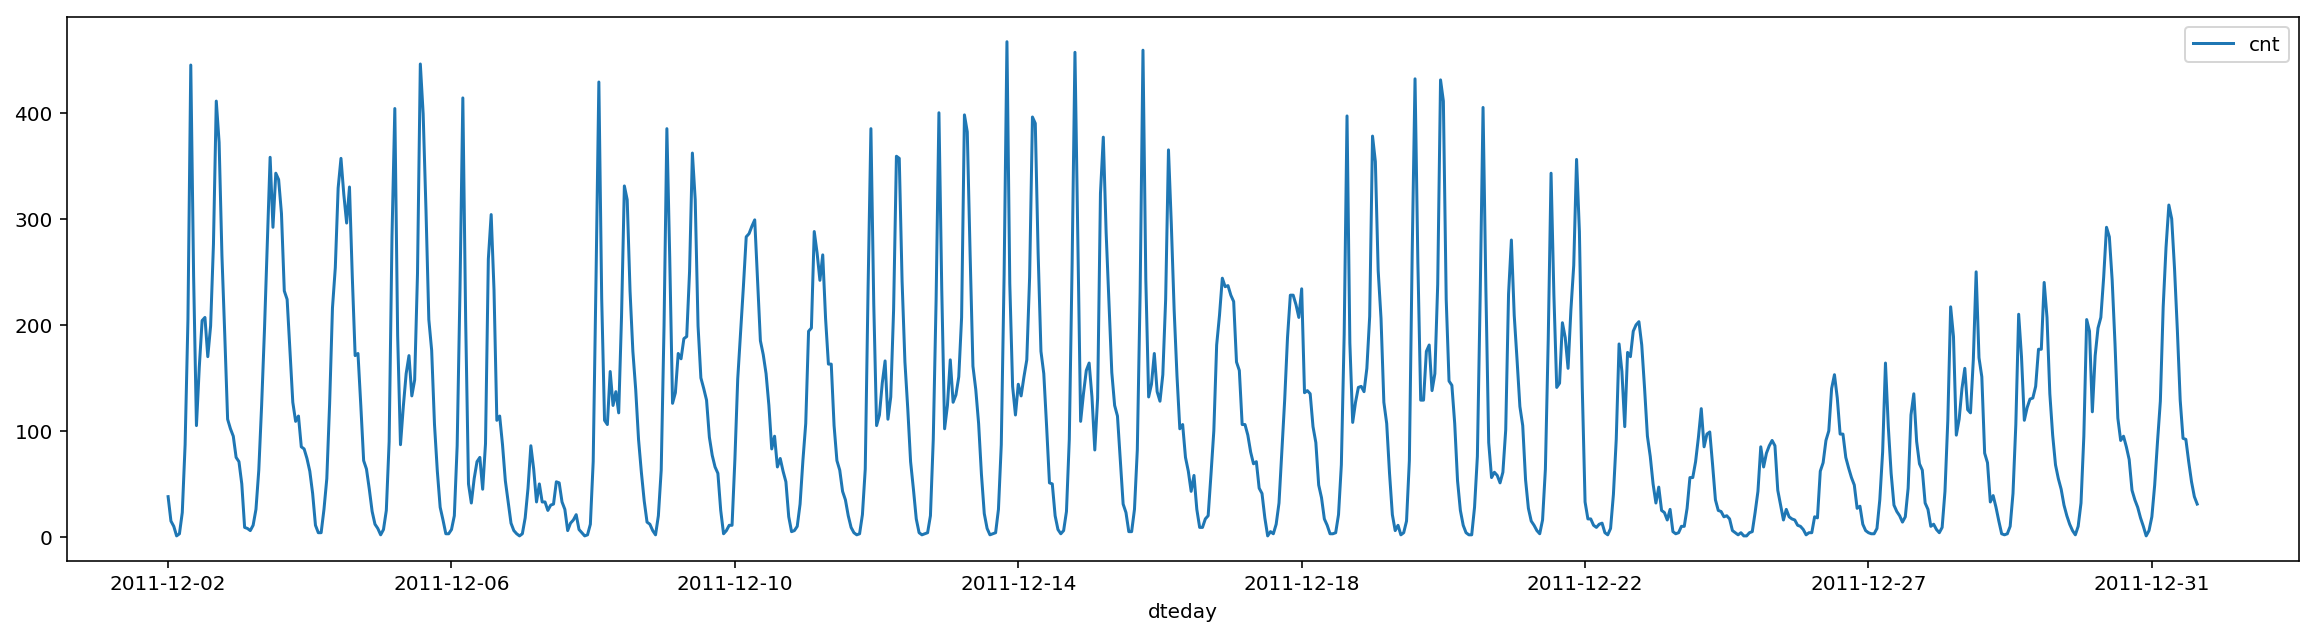

In [7]:
rides.loc[(rides['dteday'] > '2011-12-01') & (rides['dteday'] < '2012-01-01')].plot(x='dteday', y='cnt', figsize = (20,5))
plt.show()

### Dummy variables
We have some categorical variables like season, weather, month. To include these in the model, binary dummy variables are needed. 

In [8]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16         1   
1   0        0  0.22  0.80        0.0       8          32   40         1   
2   0        0  0.22  0.80        0.0       5          27   32         1   
3   0        0  0.24  0.75        0.0       3          10   13         1   
4   0        0  0.24  0.75        0.0       0           1    1         1   

   season_2  ...  hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0         0  ...      0      0      0          0          0          0   
1         0  ...      0      0      0          0          0          0   
2         0  ...      0      0      0          0          0          0   
3         0  ...      0      0      0          0          0          0   
4         0  ...      0      0      0          0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          1  
1          0          0          0          1  
2          0          0          0          1  
3          0          0          0          1  
4          0          0          0          1  

[5 rows x 59 columns]

### Scaling target variables
To make training the network easier, each of the continuous variables has been standardized. 

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [9]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

Data for the last approximately 21 days to use as a test set have been saved.

In [10]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Data have been splitted into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (holdout validation set).

In [11]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Here it is the structure of the network. The first task is to implement both the forward pass and backwards pass through the network completely using numpy. The second task is set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. 





In [12]:
from my_NN import NeuralNetwork

In [13]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Some tests to check the correctness of the network implementation. 

In [14]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Let's set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but the network doesn't overfit to the data. If the network trains too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set.

A method know as Stochastic Gradient Descent (SGD) has been used to train the network. The idea is that for each training pass, grab a random sample of the data instead of using the whole data set. This ends up training the network more efficiently. 

### Choose the number of iterations
This is the number of batches of samples from the training data used to train the network. The more iterations are used, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. 

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be. However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  



In [15]:
scores = {'iterations' : [], 'Val Min': [], 'lr': [], 'h_n' : []}

 
 Learning Rate is: 0.9
Hidden Nodes are: 9
Iterations are: 2500
Progress: 100.0% ... Training loss: 0.073 ... Validation loss: 0.158

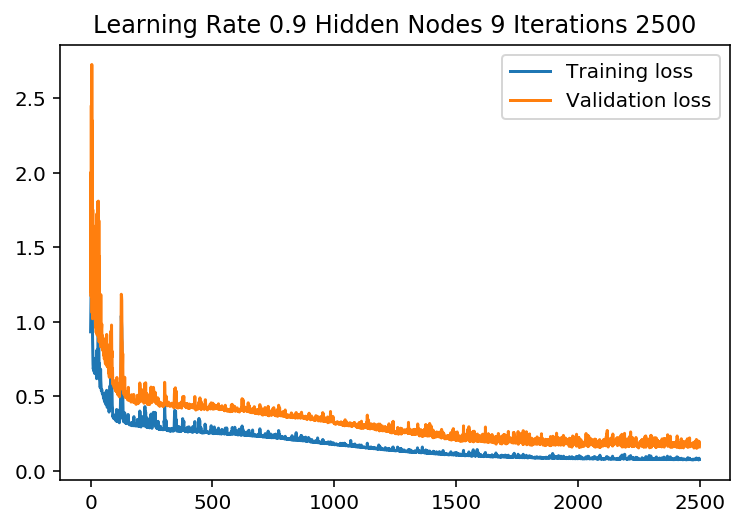

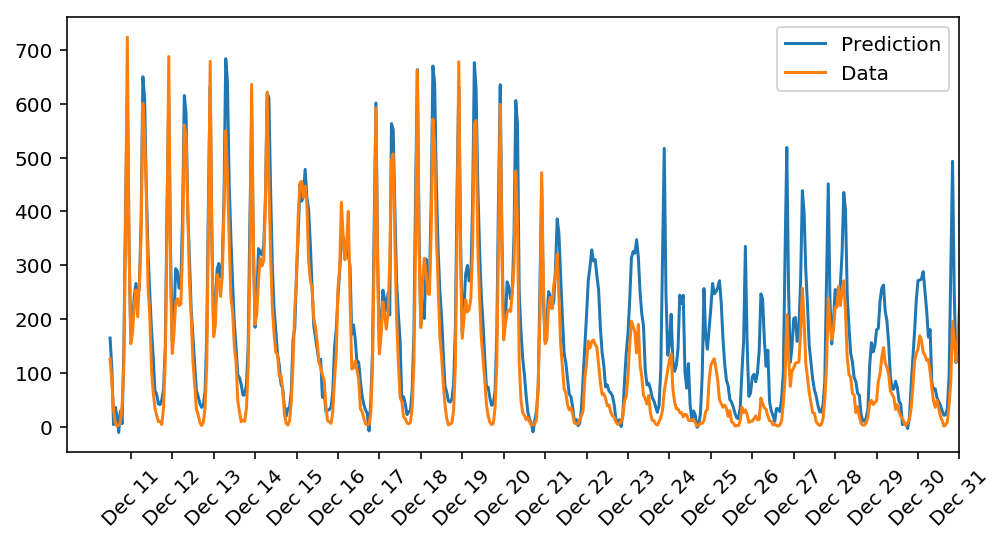

 
 Learning Rate is: 0.9
Hidden Nodes are: 10
Iterations are: 2500
Progress: 100.0% ... Training loss: 0.068 ... Validation loss: 0.153

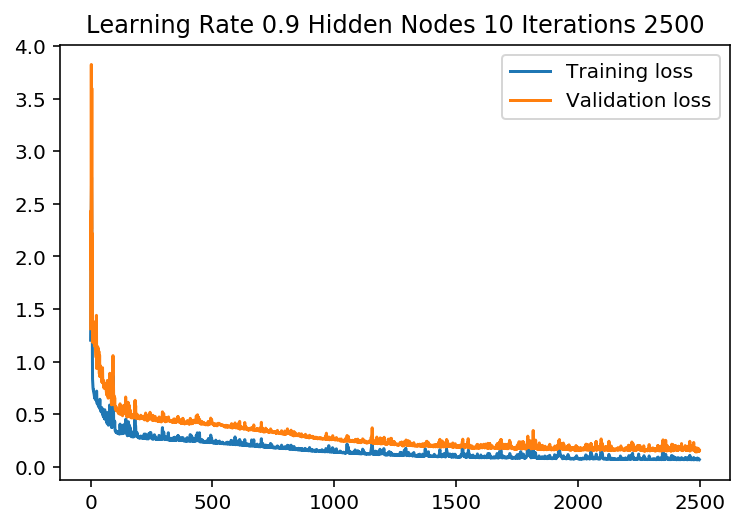

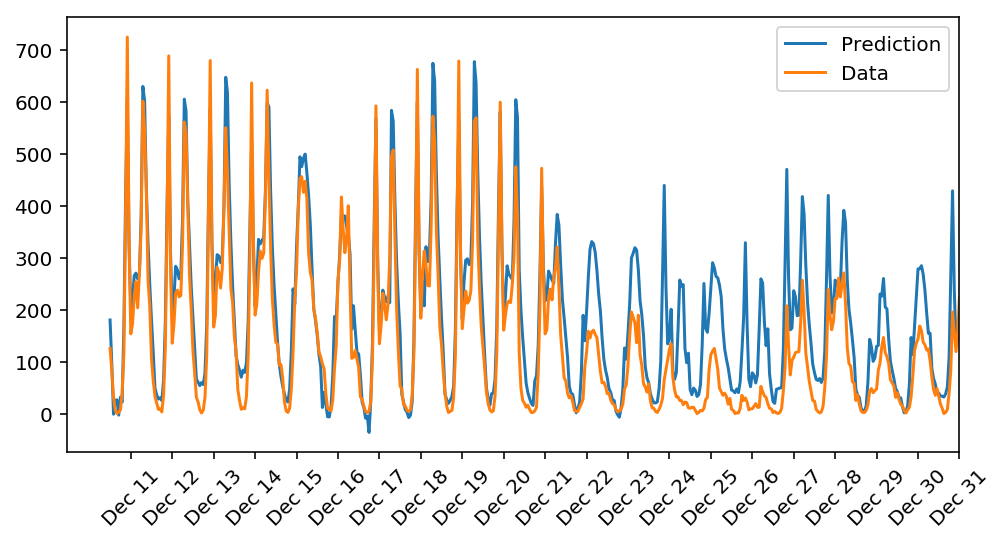

 
 Learning Rate is: 0.9
Hidden Nodes are: 11
Iterations are: 2500
Progress: 100.0% ... Training loss: 0.067 ... Validation loss: 0.152

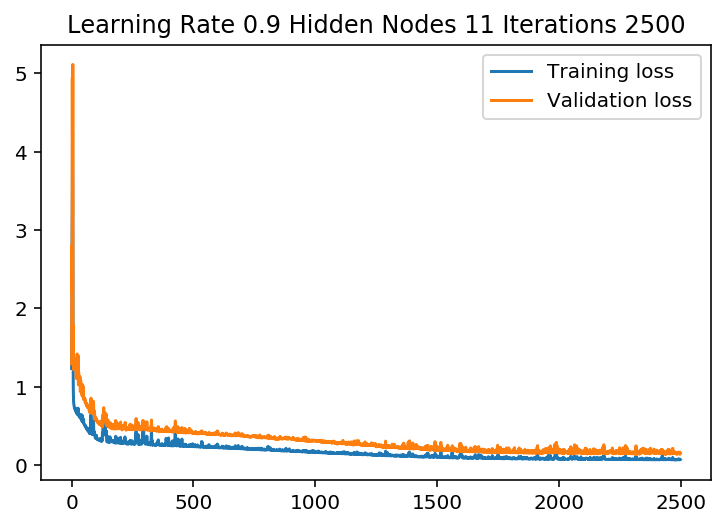

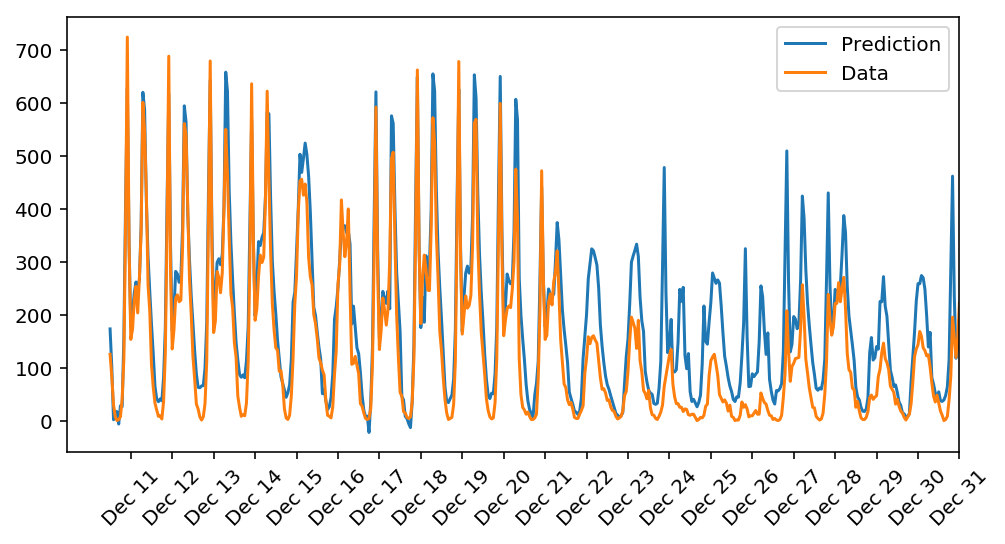

 
 Learning Rate is: 1.0
Hidden Nodes are: 9
Iterations are: 2500
Progress: 100.0% ... Training loss: 0.068 ... Validation loss: 0.139

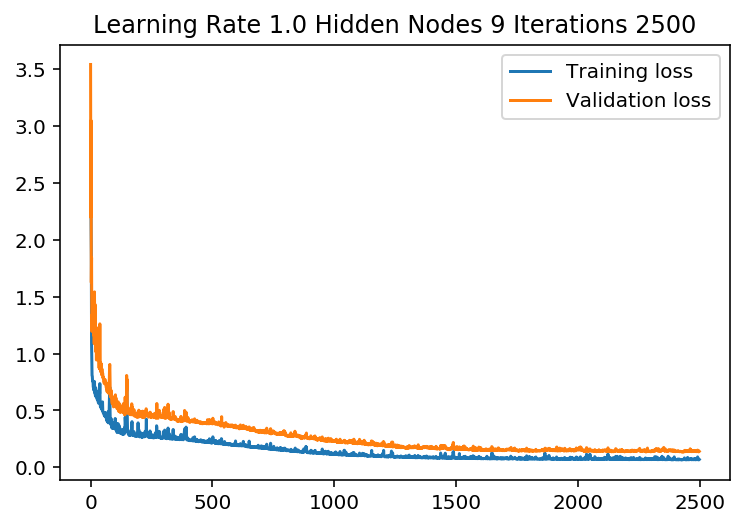

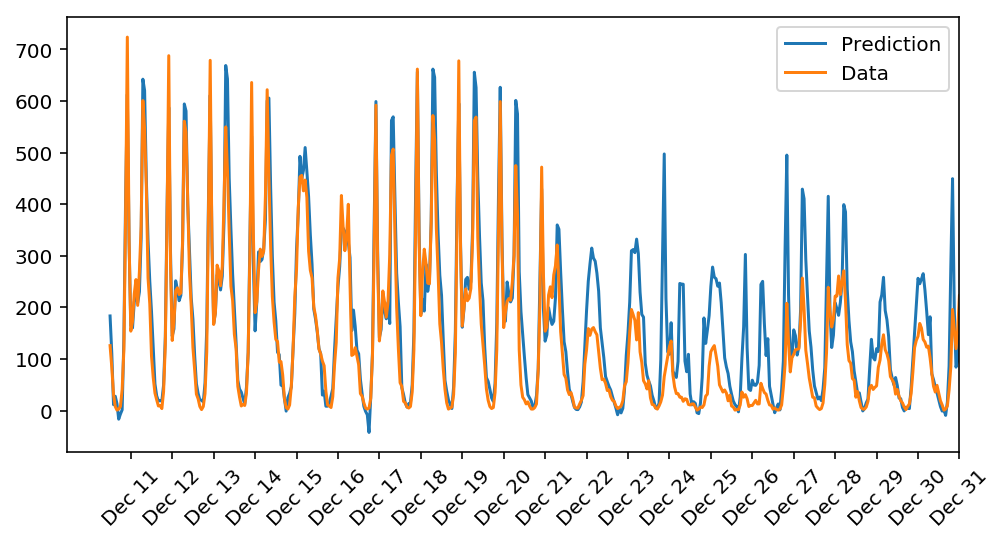

 
 Learning Rate is: 1.0
Hidden Nodes are: 10
Iterations are: 2500
Progress: 100.0% ... Training loss: 0.078 ... Validation loss: 0.143

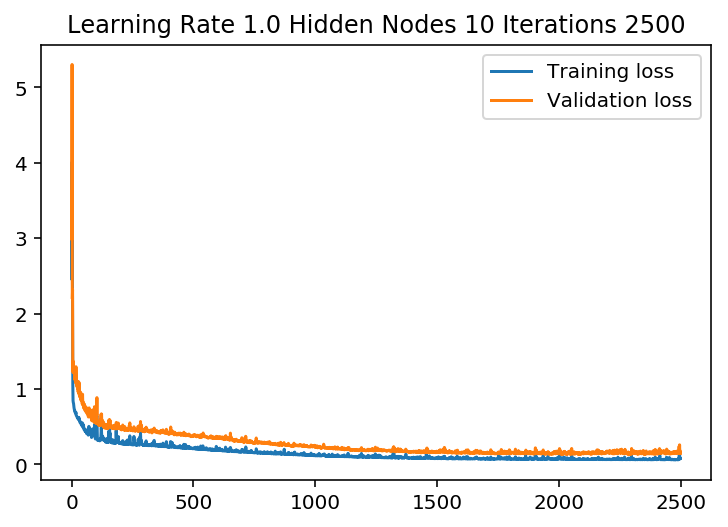

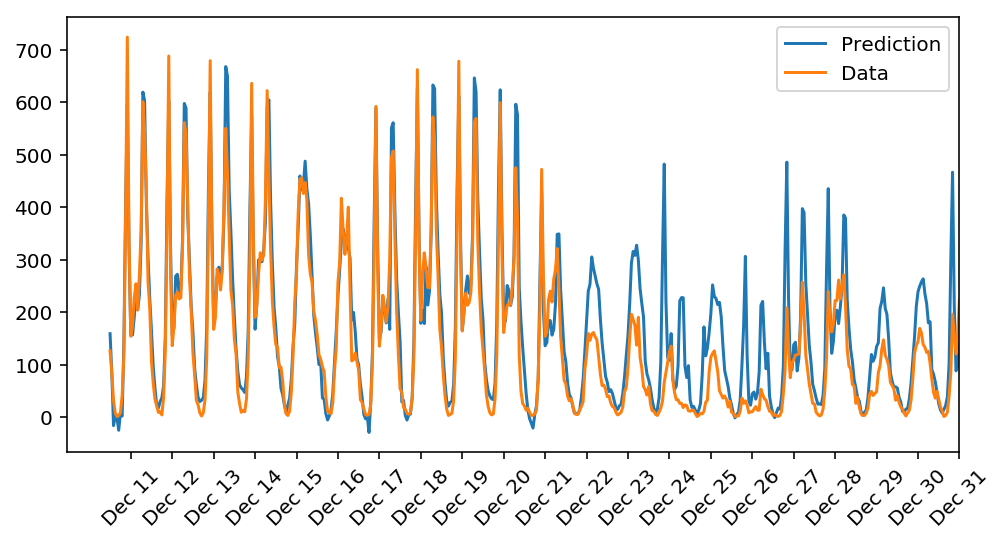

 
 Learning Rate is: 1.0
Hidden Nodes are: 11
Iterations are: 2500
Progress: 100.0% ... Training loss: 0.059 ... Validation loss: 0.152

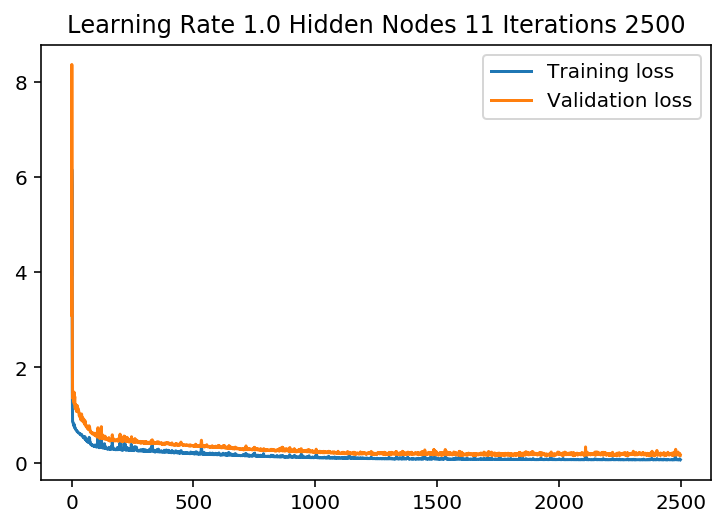

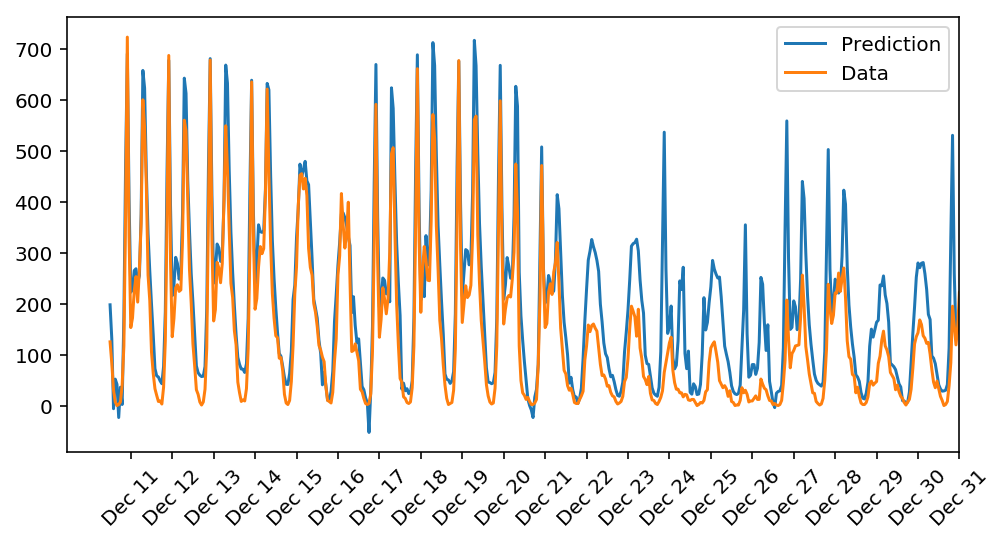

 
 Learning Rate is: 1.1
Hidden Nodes are: 9
Iterations are: 2500
Progress: 100.0% ... Training loss: 0.068 ... Validation loss: 0.189

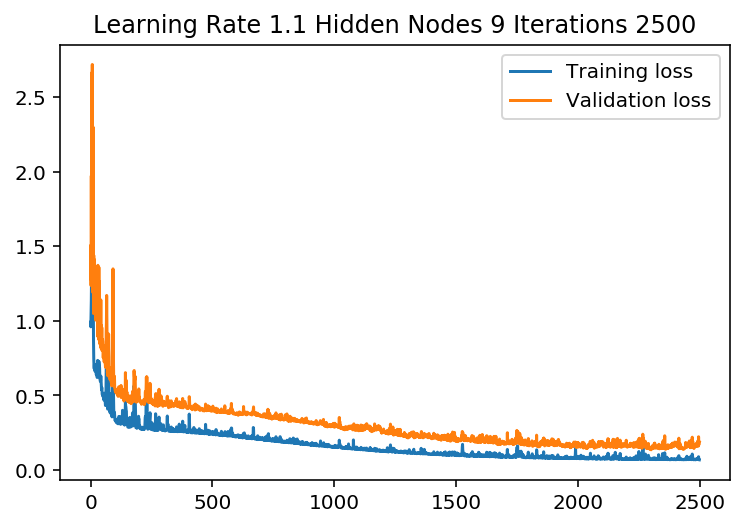

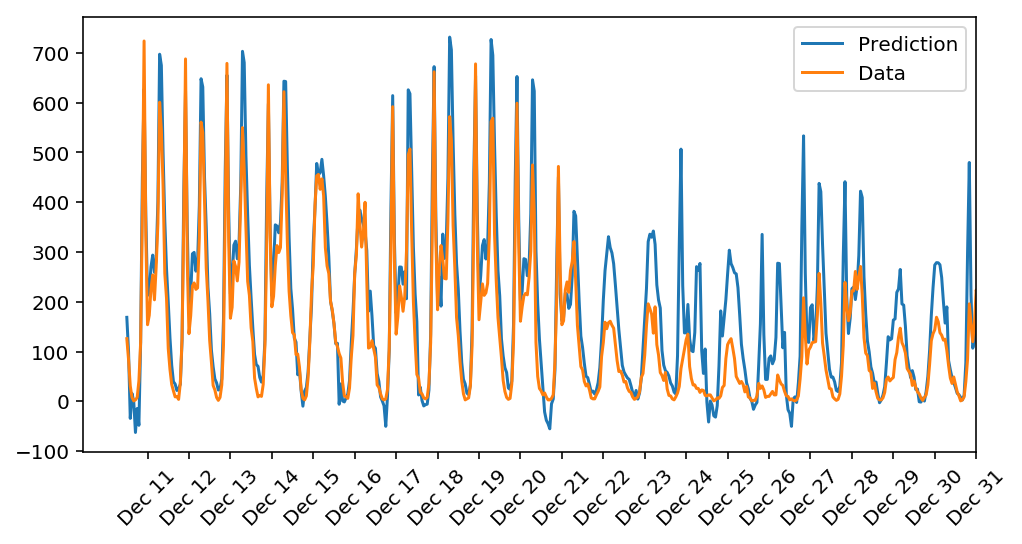

 
 Learning Rate is: 1.1
Hidden Nodes are: 10
Iterations are: 2500
Progress: 100.0% ... Training loss: 0.067 ... Validation loss: 0.159

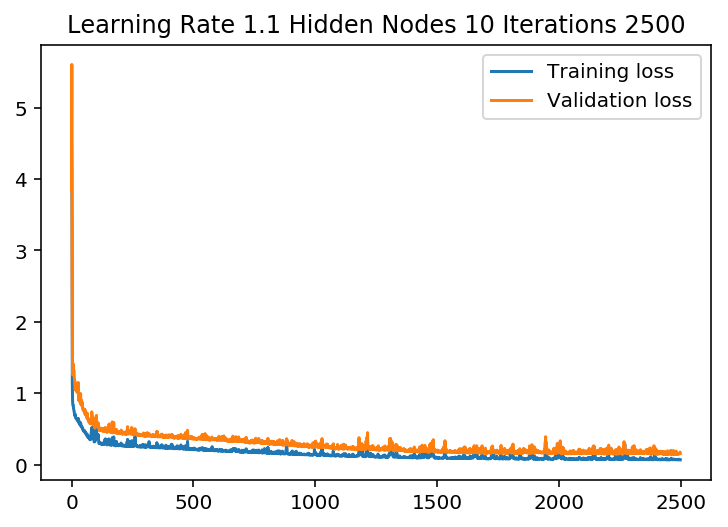

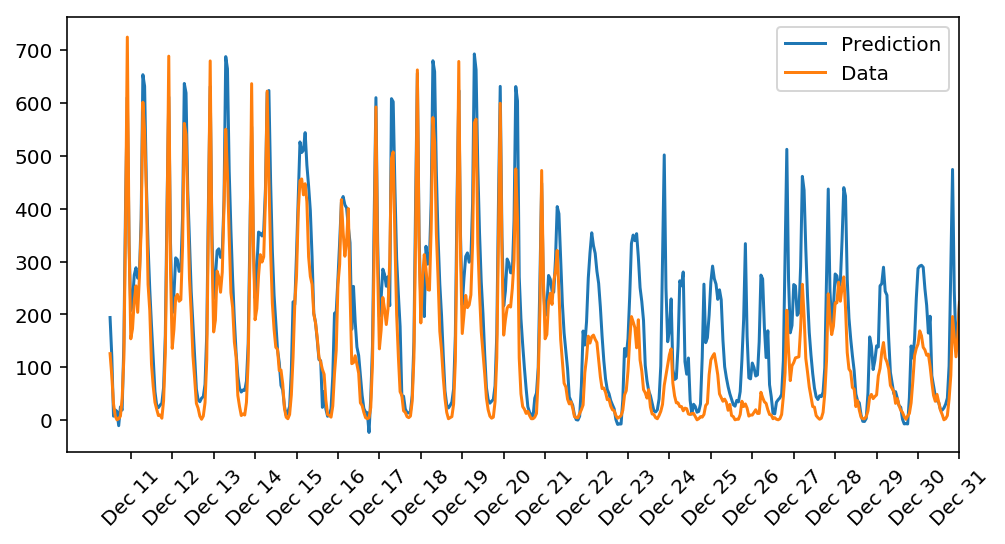

 
 Learning Rate is: 1.1
Hidden Nodes are: 11
Iterations are: 2500
Progress: 100.0% ... Training loss: 0.067 ... Validation loss: 0.148

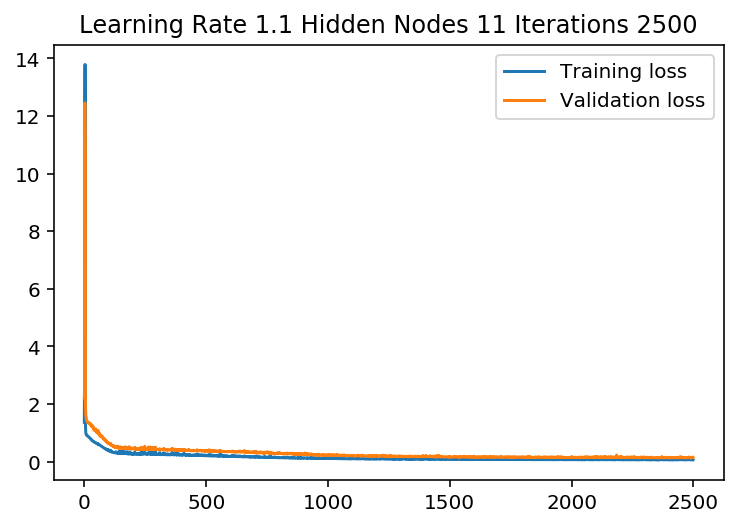

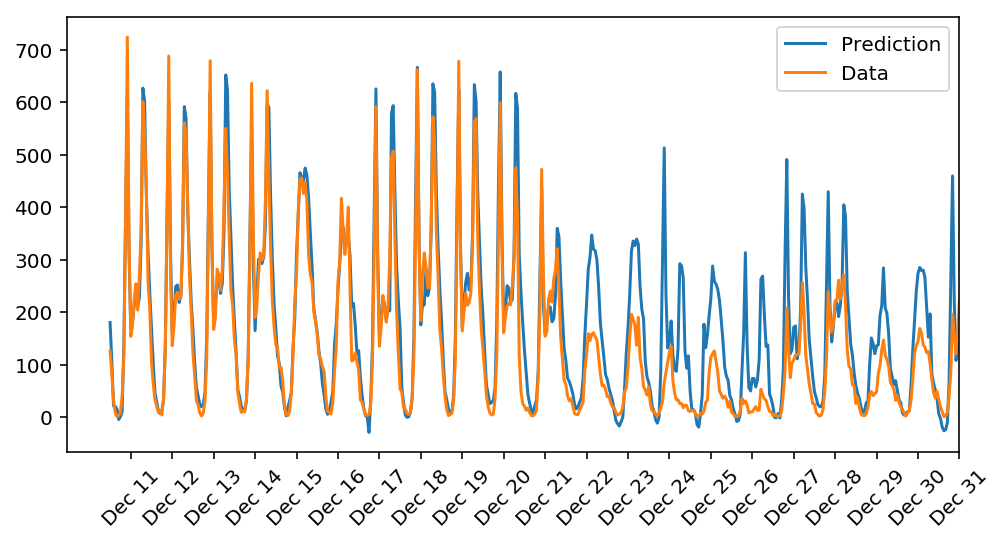

 
 Learning Rate is: 0.9
Hidden Nodes are: 9
Iterations are: 3000
Progress: 100.0% ... Training loss: 0.064 ... Validation loss: 0.183

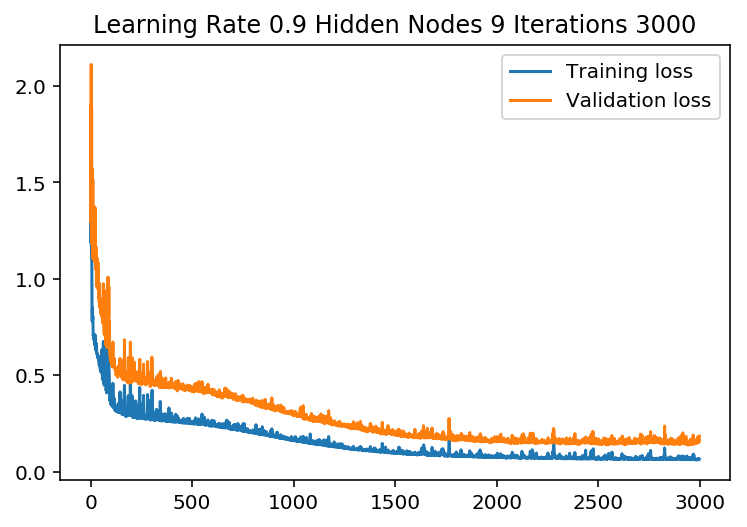

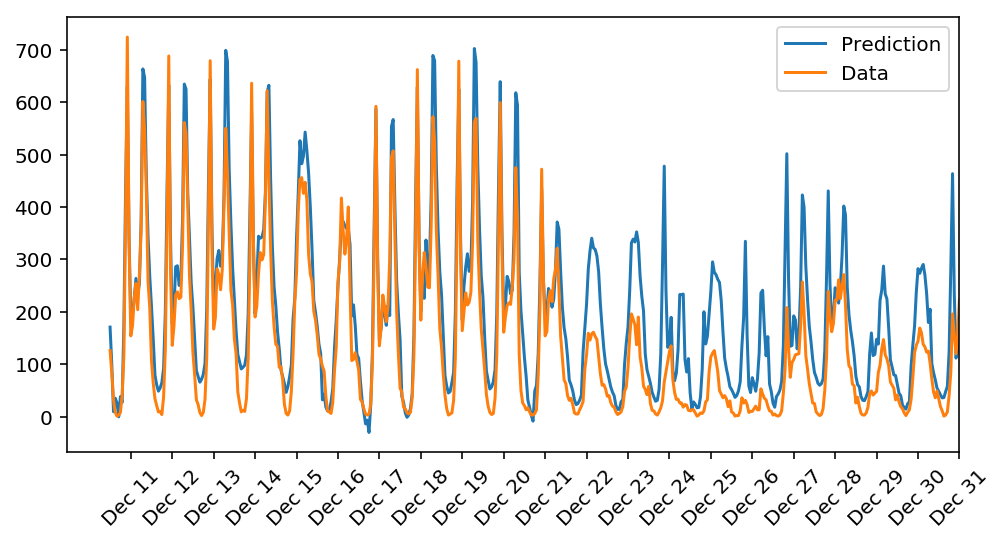

 
 Learning Rate is: 0.9
Hidden Nodes are: 10
Iterations are: 3000
Progress: 100.0% ... Training loss: 0.064 ... Validation loss: 0.156

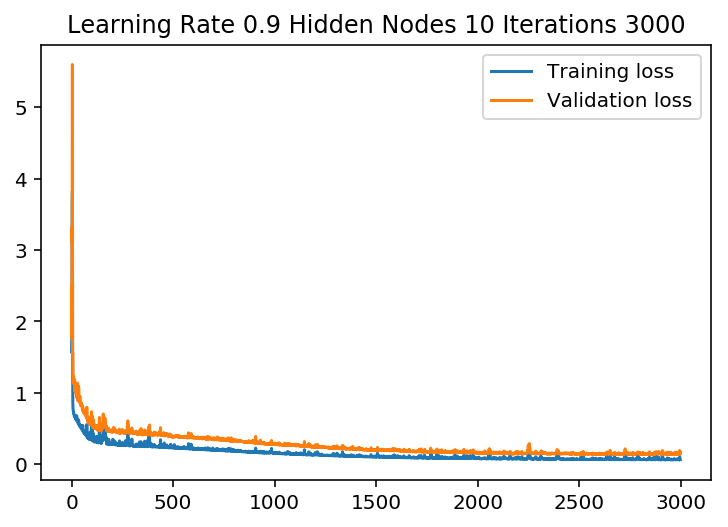

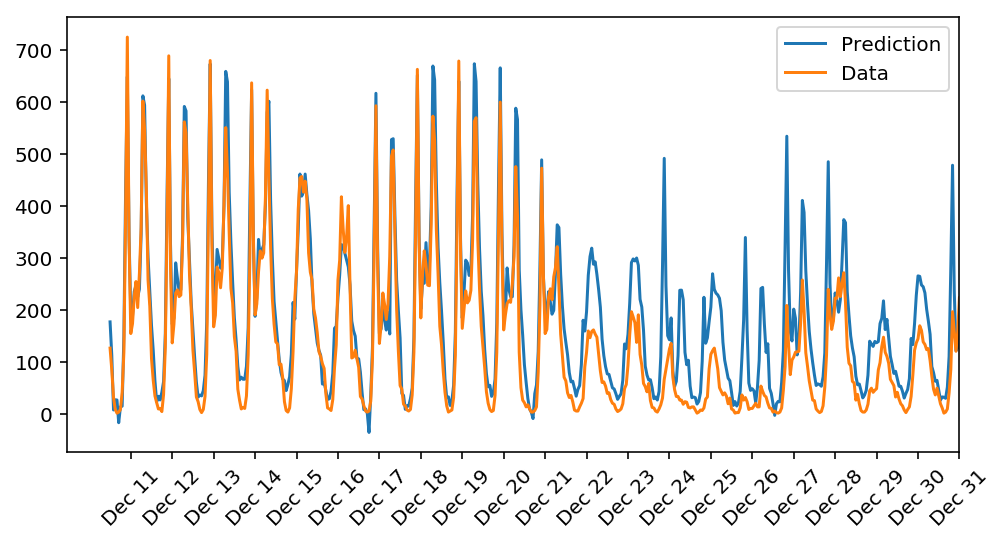

 
 Learning Rate is: 0.9
Hidden Nodes are: 11
Iterations are: 3000
Progress: 100.0% ... Training loss: 0.072 ... Validation loss: 0.167

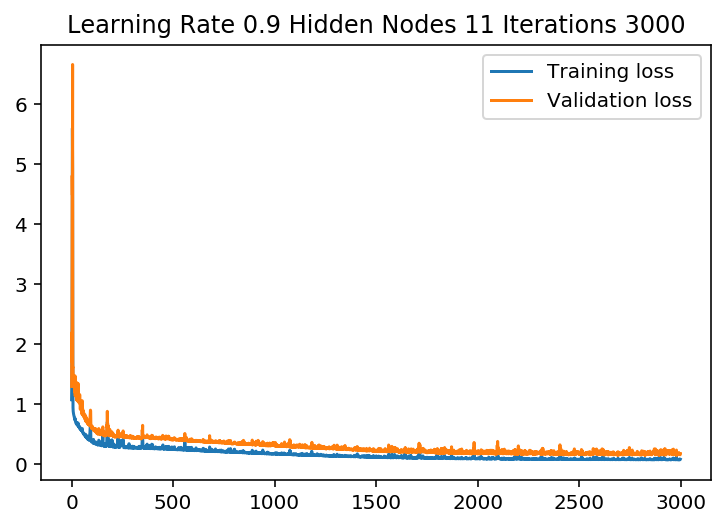

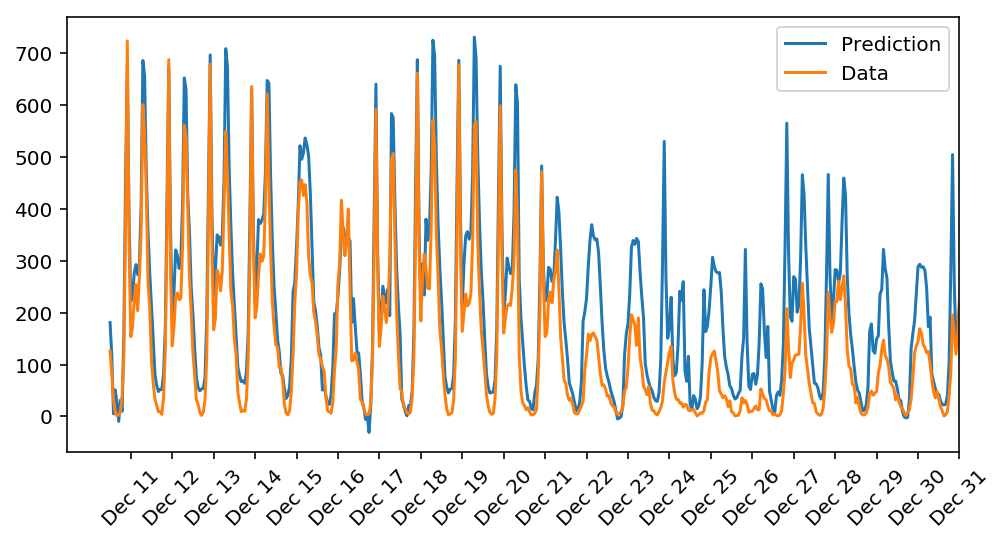

 
 Learning Rate is: 1.0
Hidden Nodes are: 9
Iterations are: 3000
Progress: 100.0% ... Training loss: 0.071 ... Validation loss: 0.158

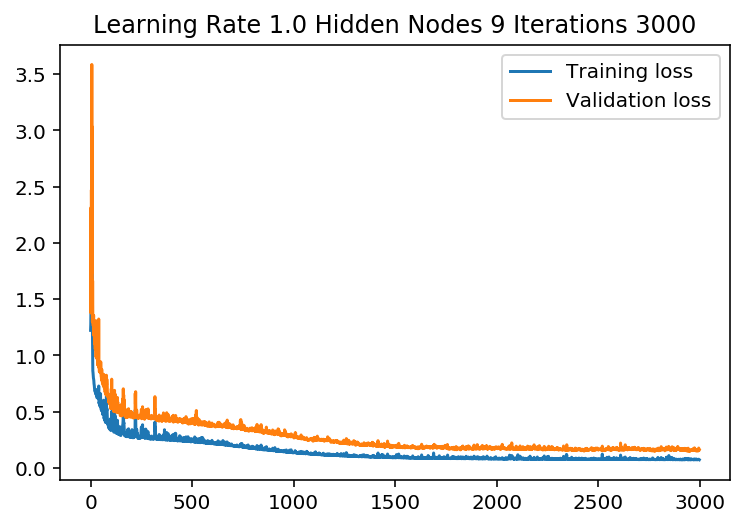

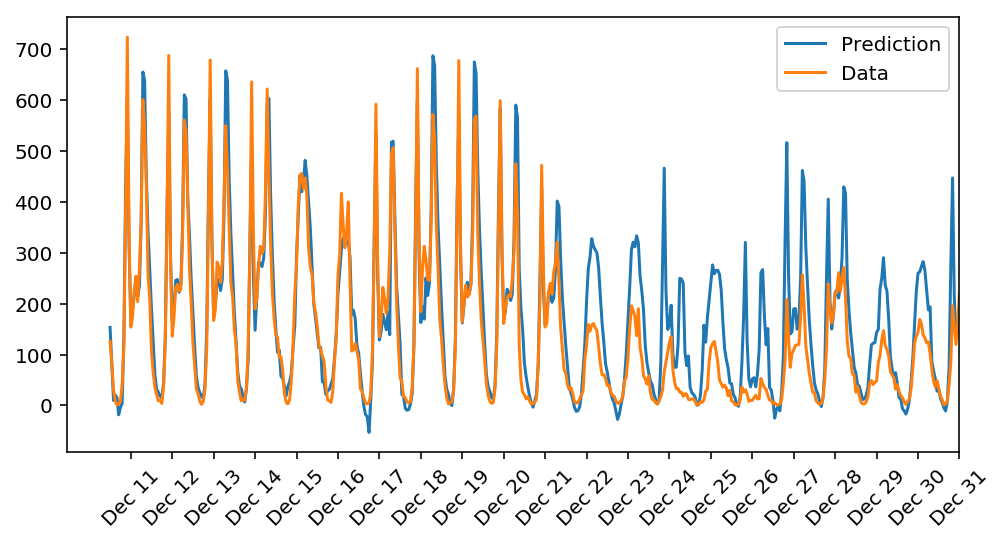

 
 Learning Rate is: 1.0
Hidden Nodes are: 10
Iterations are: 3000
Progress: 100.0% ... Training loss: 0.063 ... Validation loss: 0.143

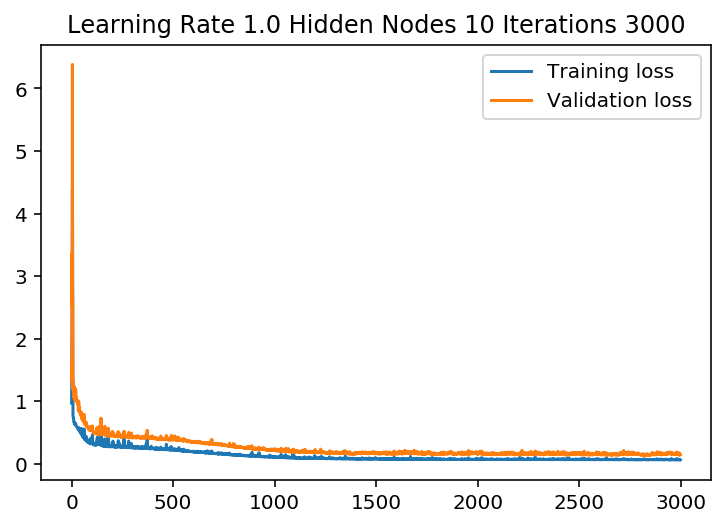

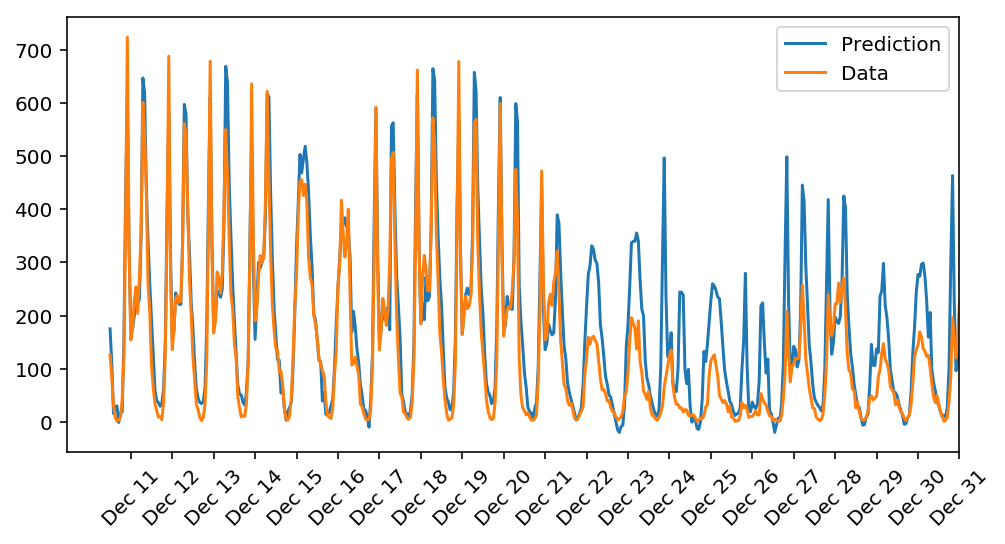

 
 Learning Rate is: 1.0
Hidden Nodes are: 11
Iterations are: 3000
Progress: 100.0% ... Training loss: 0.058 ... Validation loss: 0.130

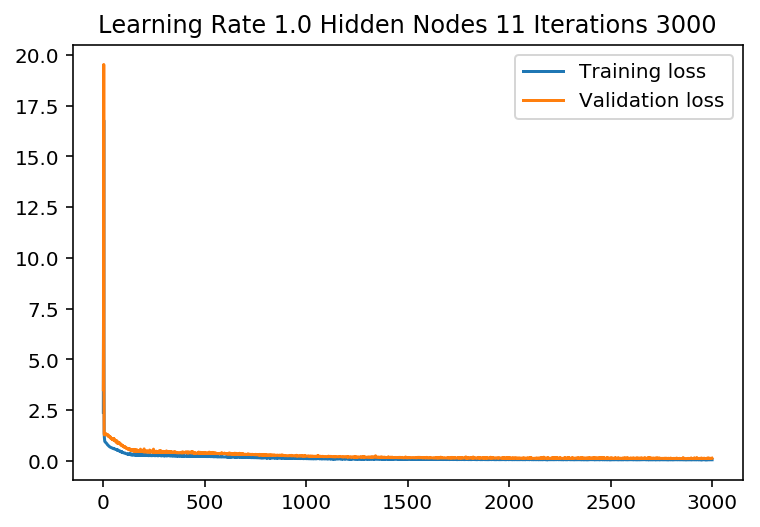

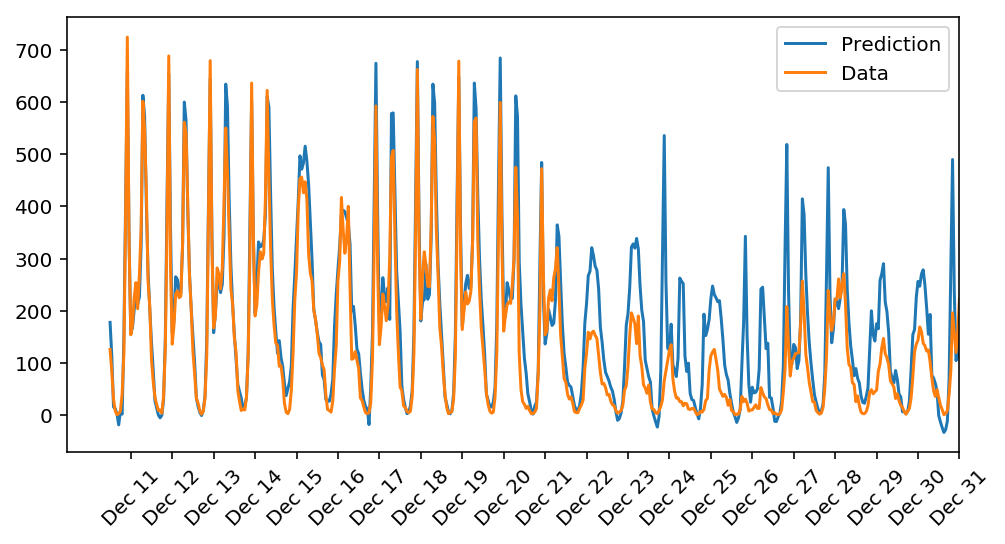

 
 Learning Rate is: 1.1
Hidden Nodes are: 9
Iterations are: 3000
Progress: 100.0% ... Training loss: 0.062 ... Validation loss: 0.161

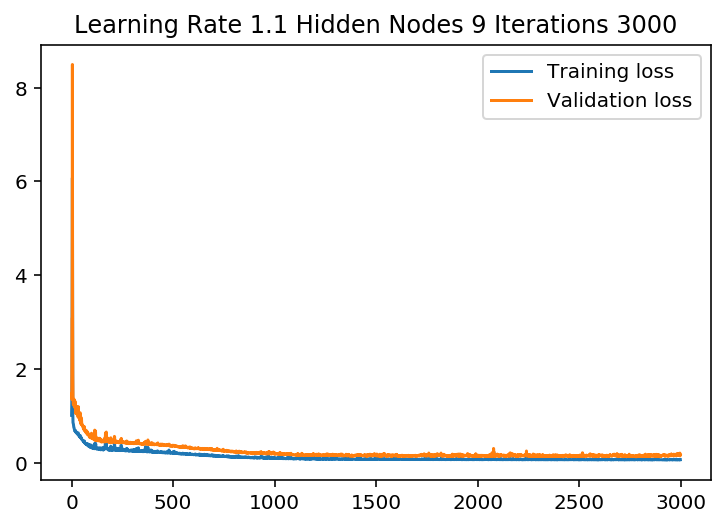

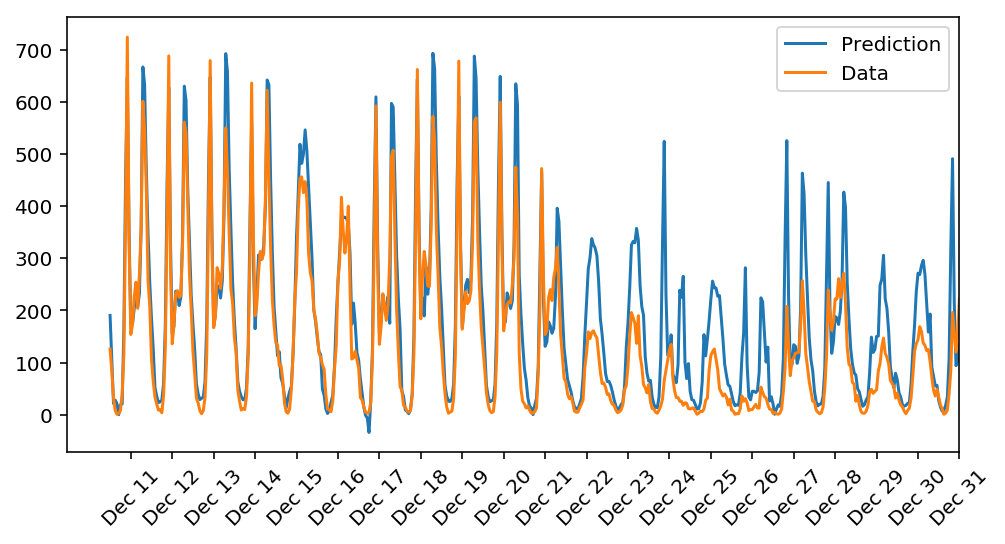

 
 Learning Rate is: 1.1
Hidden Nodes are: 10
Iterations are: 3000
Progress: 100.0% ... Training loss: 0.062 ... Validation loss: 0.159

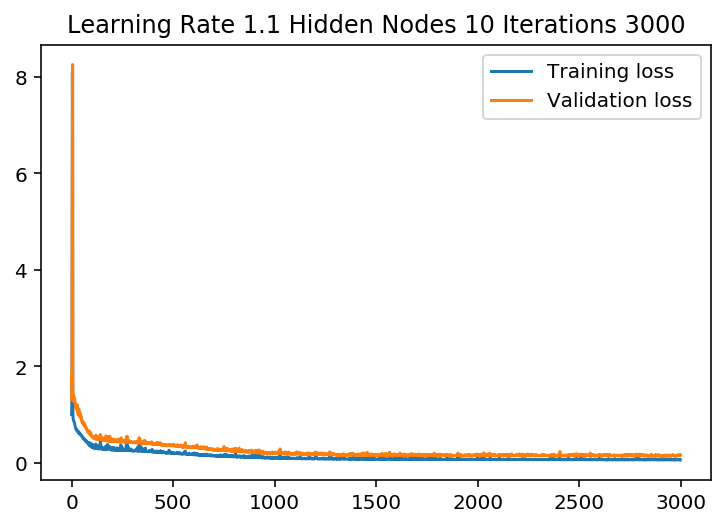

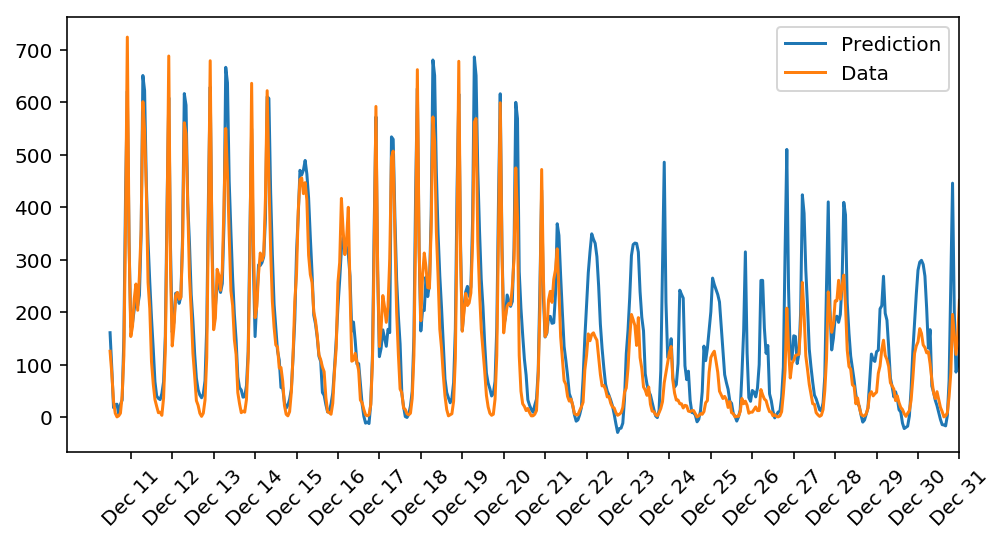

 
 Learning Rate is: 1.1
Hidden Nodes are: 11
Iterations are: 3000
Progress: 100.0% ... Training loss: 0.072 ... Validation loss: 0.155

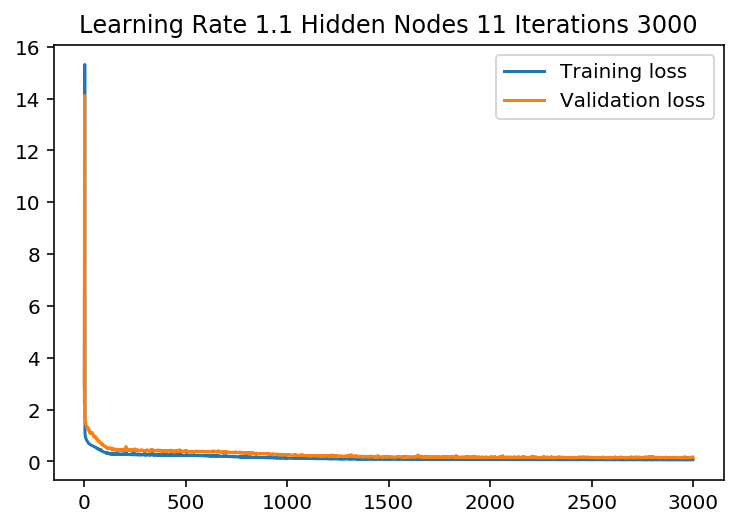

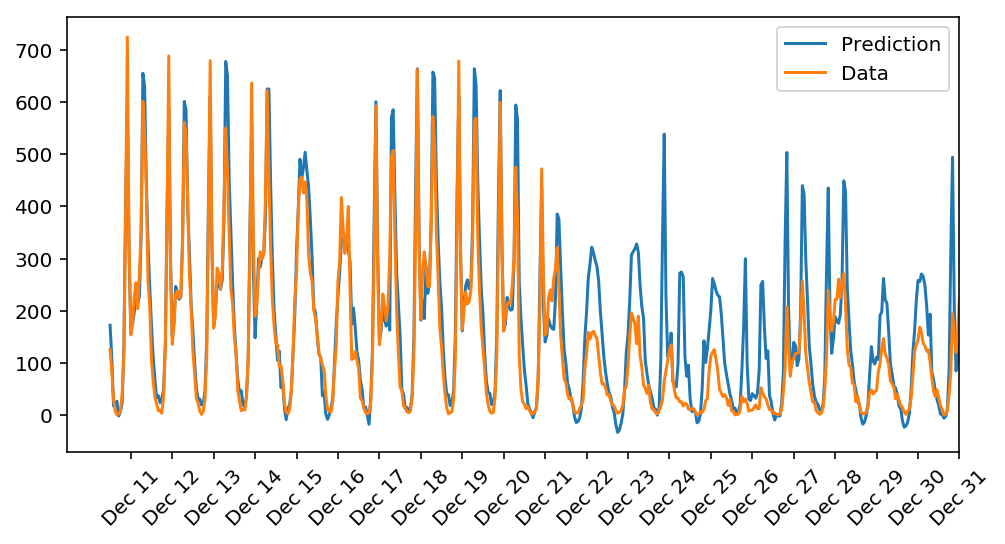

 
 Learning Rate is: 0.9
Hidden Nodes are: 9
Iterations are: 3500
Progress: 100.0% ... Training loss: 0.086 ... Validation loss: 0.278

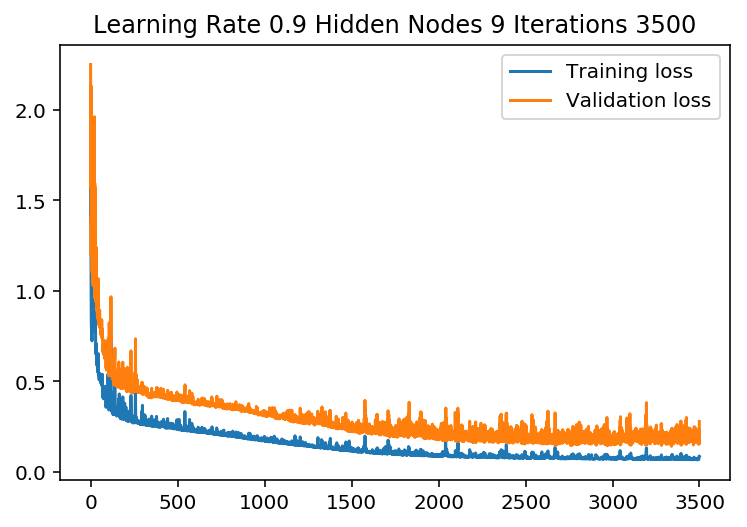

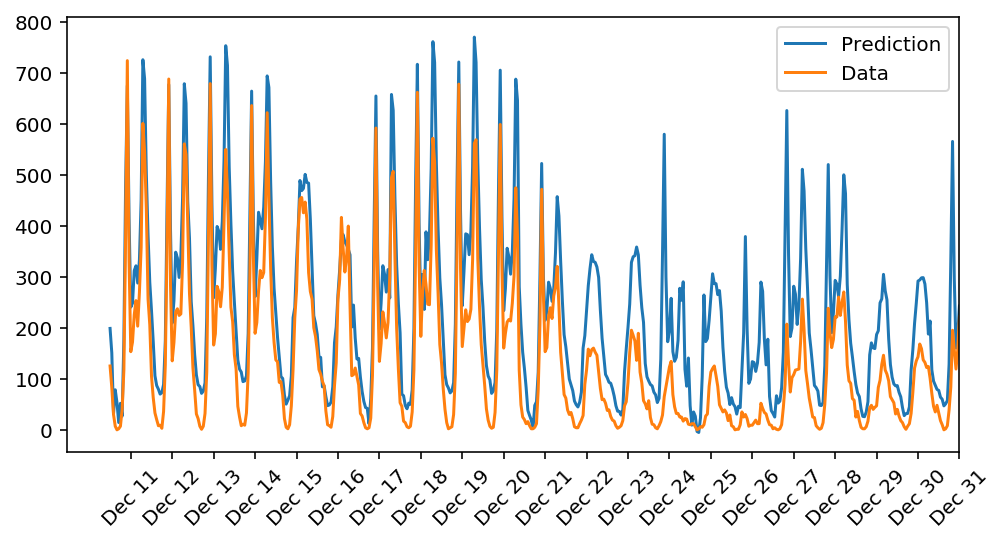

 
 Learning Rate is: 0.9
Hidden Nodes are: 10
Iterations are: 3500
Progress: 100.0% ... Training loss: 0.079 ... Validation loss: 0.198

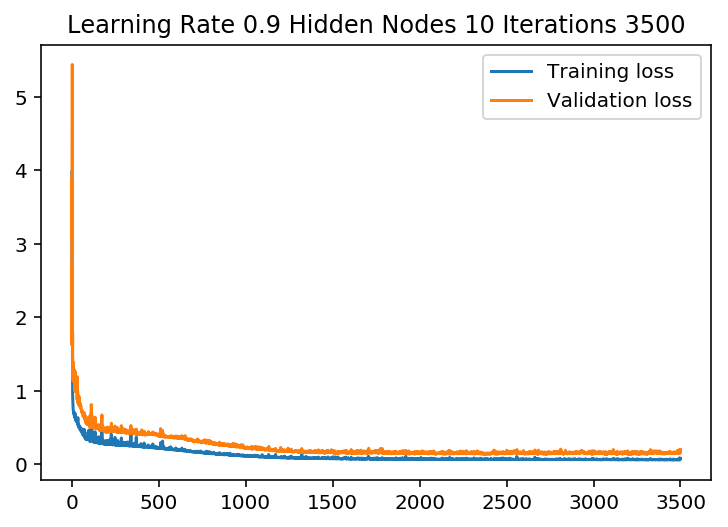

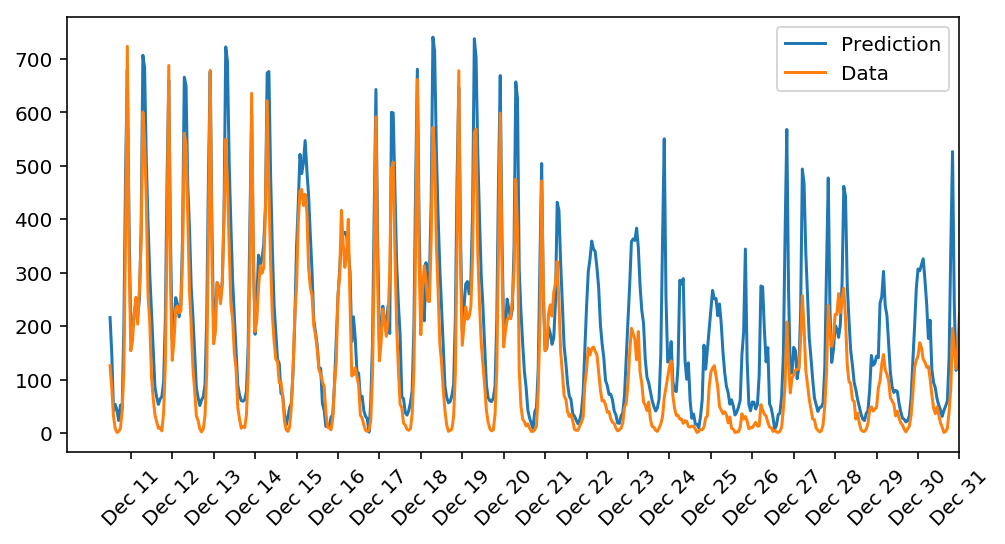

 
 Learning Rate is: 0.9
Hidden Nodes are: 11
Iterations are: 3500
Progress: 100.0% ... Training loss: 0.059 ... Validation loss: 0.140

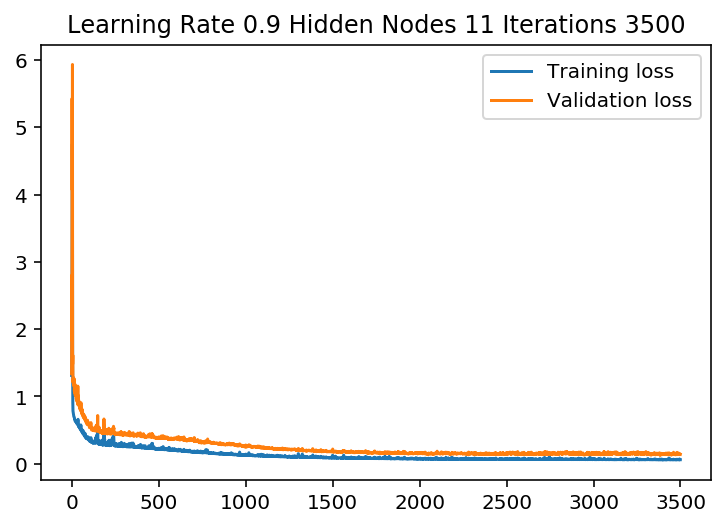

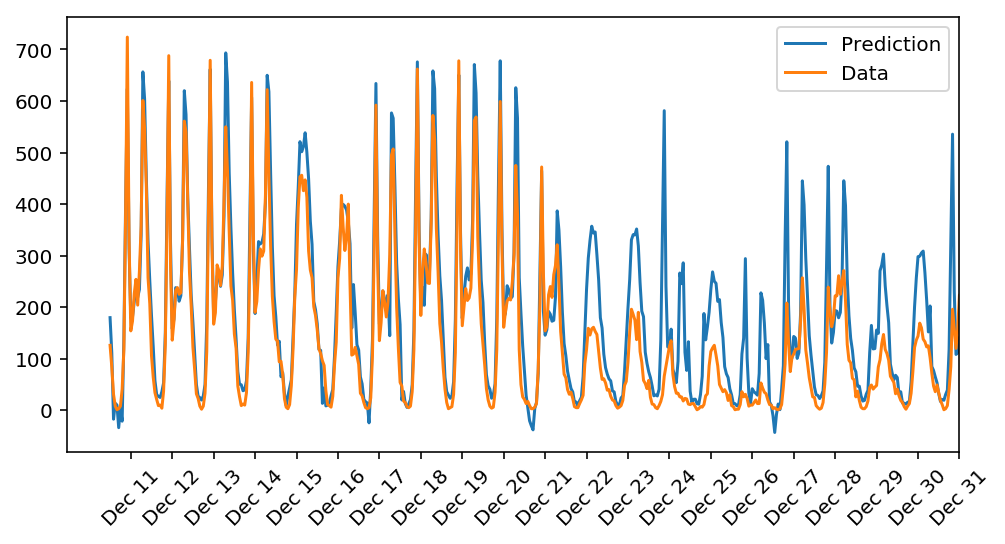

 
 Learning Rate is: 1.0
Hidden Nodes are: 9
Iterations are: 3500
Progress: 100.0% ... Training loss: 0.062 ... Validation loss: 0.156

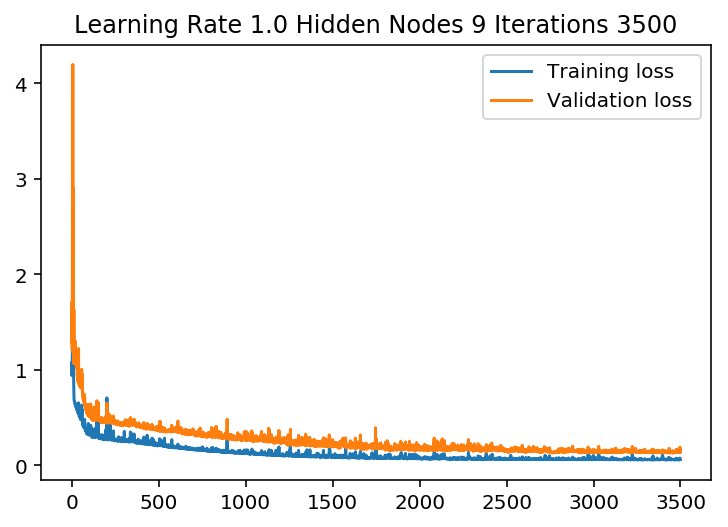

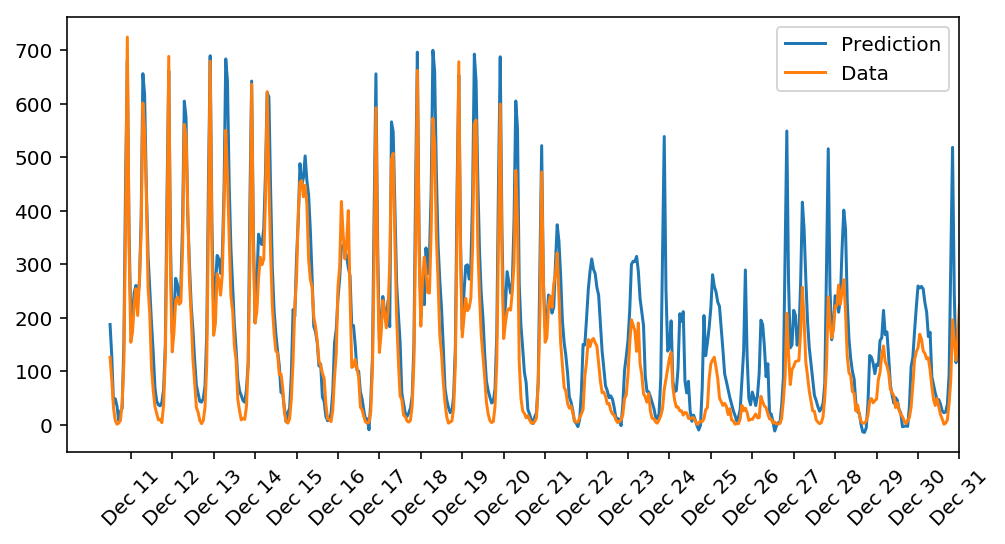

 
 Learning Rate is: 1.0
Hidden Nodes are: 10
Iterations are: 3500
Progress: 100.0% ... Training loss: 0.065 ... Validation loss: 0.172

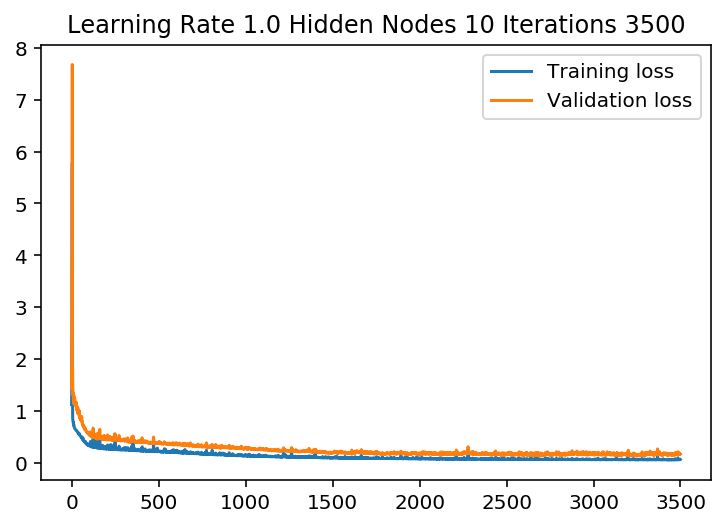

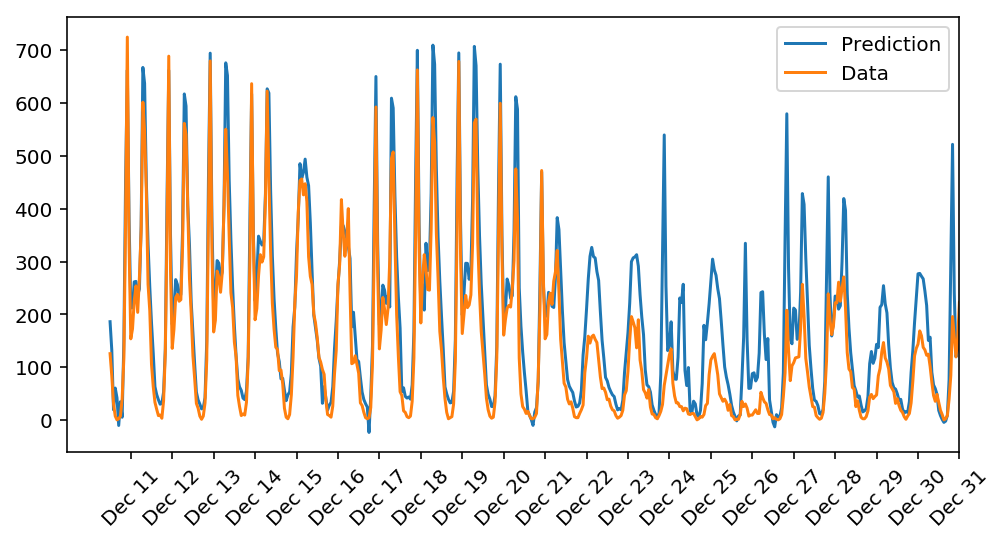

 
 Learning Rate is: 1.0
Hidden Nodes are: 11
Iterations are: 3500
Progress: 100.0% ... Training loss: 0.062 ... Validation loss: 0.158

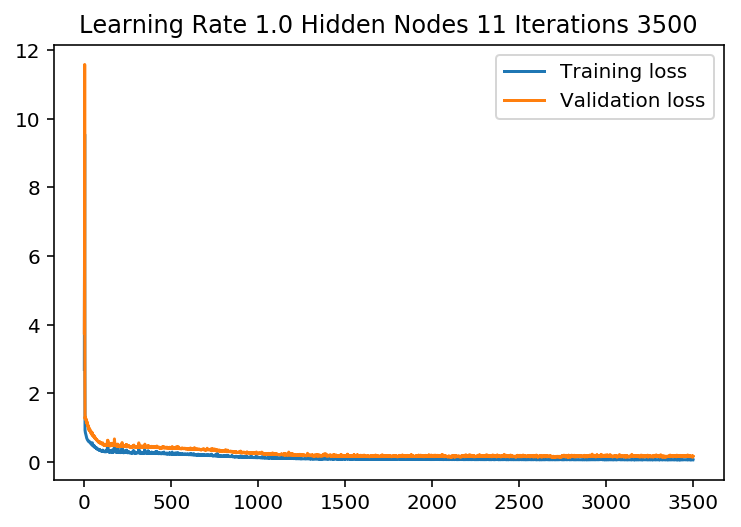

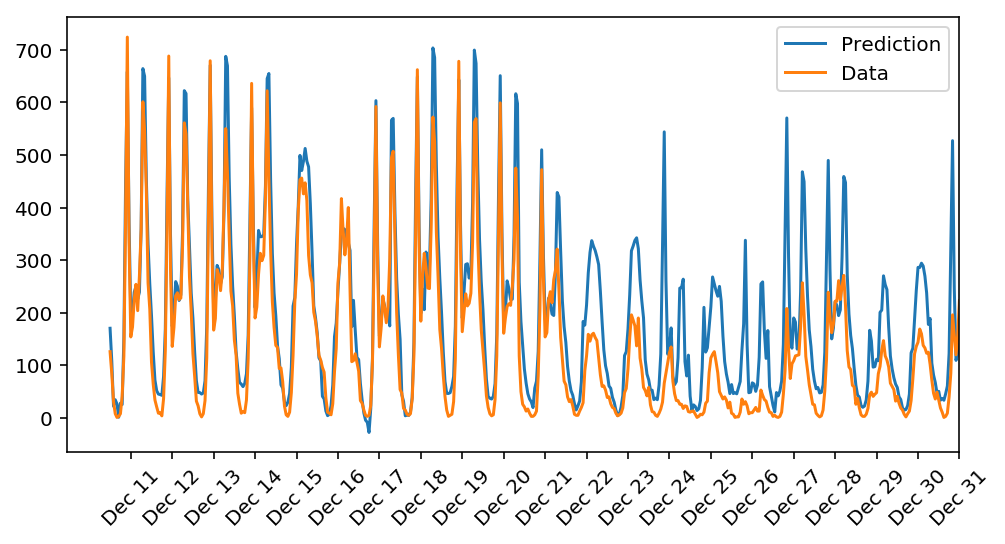

 
 Learning Rate is: 1.1
Hidden Nodes are: 9
Iterations are: 3500
Progress: 100.0% ... Training loss: 0.061 ... Validation loss: 0.142

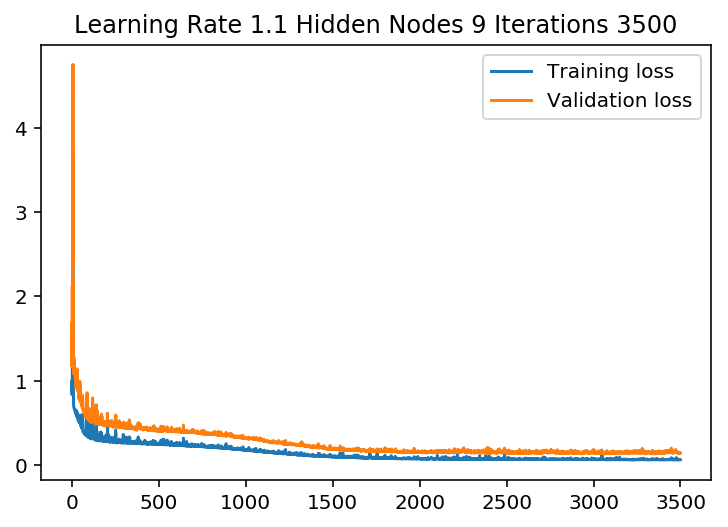

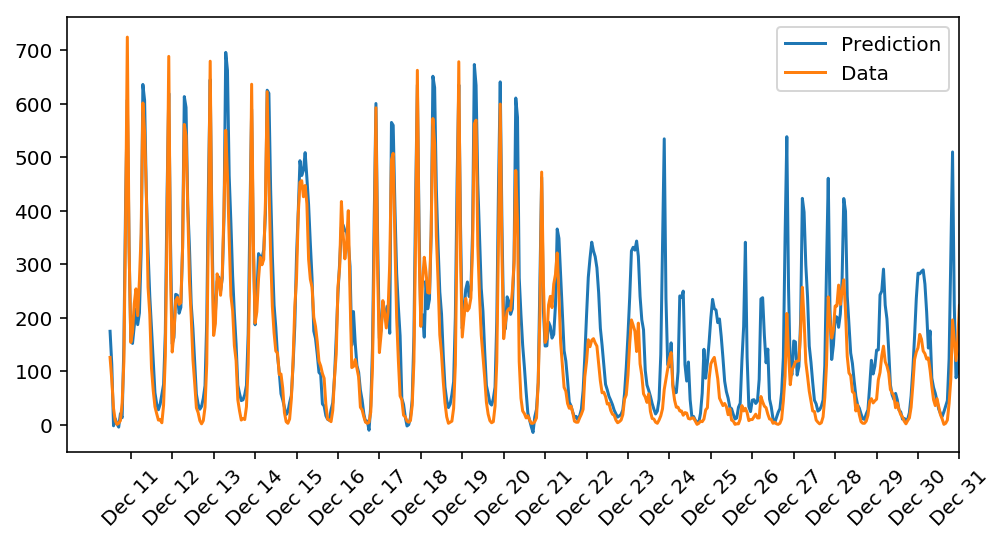

 
 Learning Rate is: 1.1
Hidden Nodes are: 10
Iterations are: 3500
Progress: 100.0% ... Training loss: 0.064 ... Validation loss: 0.158

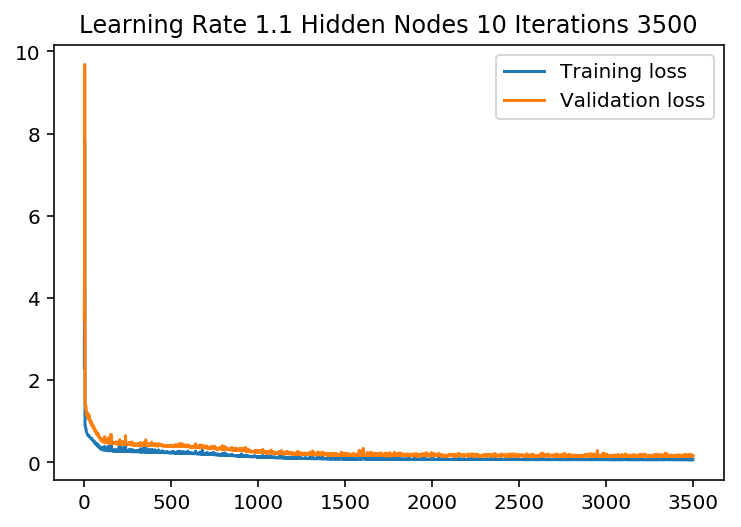

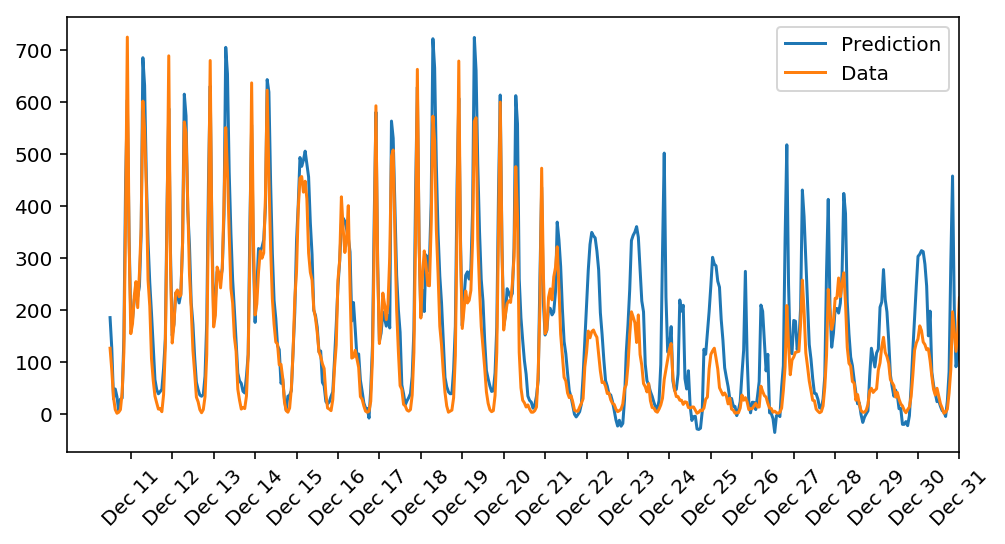

 
 Learning Rate is: 1.1
Hidden Nodes are: 11
Iterations are: 3500
Progress: 100.0% ... Training loss: 0.058 ... Validation loss: 0.130

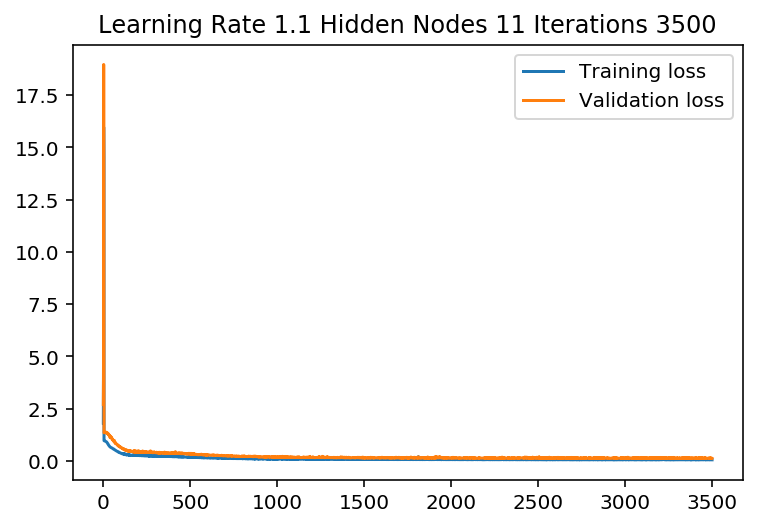

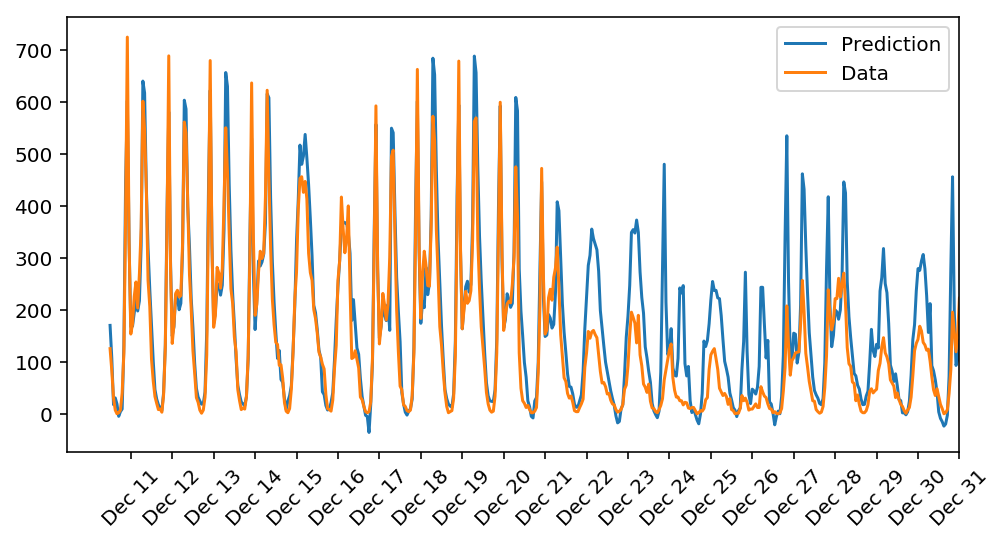

In [16]:
import sys



from my_NN import iterations, learning_rate, hidden_nodes, output_nodes
lr = np.arange(0.9,1.2,0.1)
h_n = [i for i in range(9,12,1)]
iter_ = [2500,3000,3500]

for iterations in iter_:
    for learning_rate in lr:
        for hidden_nodes in h_n:
            print(" \n Learning Rate is: " + str(learning_rate))
            print("Hidden Nodes are: " + str(hidden_nodes))
            print("Iterations are: " + str(iterations))
            
            N_i = train_features.shape[1]
            network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

            losses = {'train':[], 'validation':[]}
            for ii in range(iterations):
            # Go through a random batch of 128 records from the training data set
                batch = np.random.choice(train_features.index, size=128)
                X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']

                network.train(X, y)

            # Printing out the training progress
                train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
                val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
                sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                             + "% ... Training loss: " + str(train_loss)[:5] \
                             + " ... Validation loss: " + str(val_loss)[:5])
                sys.stdout.flush()

                losses['train'].append(train_loss)
                losses['validation'].append(val_loss)
            scores['iterations'].append(iterations)
            scores['Val Min'].append(min(losses['validation']))
            scores['lr'].append(learning_rate)
            scores['h_n'].append(hidden_nodes)



            #### Plot
            plt.plot(losses['train'], label='Training loss')
            plt.plot(losses['validation'], label='Validation loss')
            plt.legend()
            plt.title('Learning Rate ' + str(learning_rate) + ' Hidden Nodes ' + str(hidden_nodes) + ' Iterations ' + str(iterations))
            _ = plt.ylim()
            plt.show()
            
            fig, ax = plt.subplots(figsize=(8,4))

            mean, std = scaled_features['cnt']
            predictions = network.run(test_features).T*std + mean
            ax.plot(predictions[0], label='Prediction')
            ax.plot((test_targets['cnt']*std + mean).values, label='Data')
            ax.set_xlim(right=len(predictions))
            ax.legend()

            dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
            dates = dates.apply(lambda d: d.strftime('%b %d'))
            ax.set_xticks(np.arange(len(dates))[12::24])
            _ = ax.set_xticklabels(dates[12::24], rotation=45)
            plt.show()

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

In [17]:
stats = pd.DataFrame(scores)

In [18]:
stats.loc[stats['Val Min'] == stats['Val Min'].min()]

iterations   Val Min   lr  h_n
14        3000  0.115843  1.0   11

In [20]:
import sys

#Train with the best Hyperparameters set found

from my_NN import iterations, learning_rate, hidden_nodes, output_nodes

print(" \n Learning Rate is: " + str(learning_rate))
print("Hidden Nodes are: " + str(hidden_nodes))
print("Iterations are: " + str(iterations))

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
# Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']

    network.train(X, y)

# Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                 + "% ... Training loss: " + str(train_loss)[:5] \
                 + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()

    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)




         

 
 Learning Rate is: 1
Hidden Nodes are: 11
Iterations are: 2900
Progress: 100.0% ... Training loss: 0.083 ... Validation loss: 0.148

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Predictions


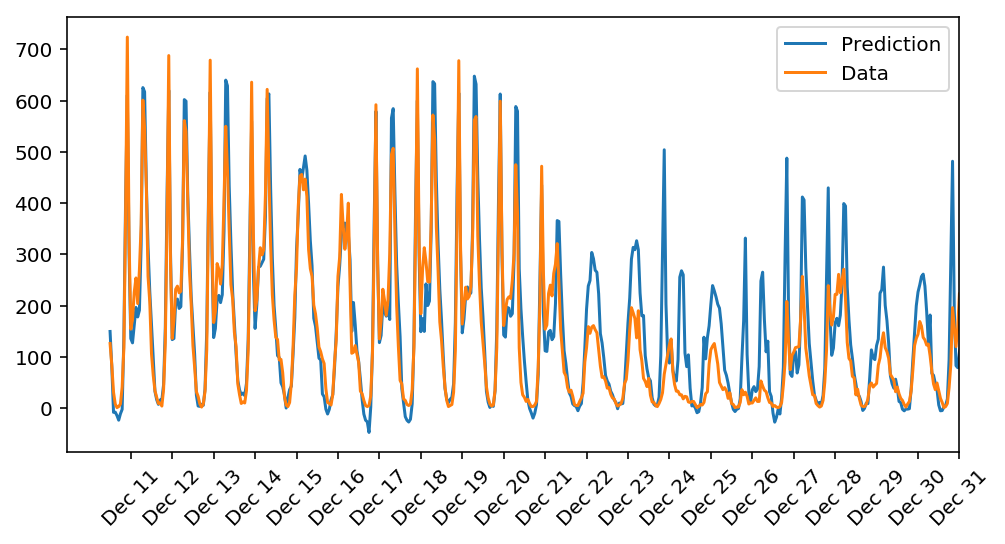

In [21]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)